# **NLOGpy**

This workflow allows you to pull lithostratigraphy and well data of a field from [Netherland Oil and Gas Portal](https://www.nlog.nl/datacenter/). It will save lithostratigraphy data of each well as a single JSON file and collect well informations as a pandas dataframe. I choose The Groningen Field in this example, a well-studied, prolific gas field in the Netherlands with 300+ wells which I want to play around with the data later on. But, feel free to use and modify it to pull another field dataset to serve for your own purpose.

This package is not authored, or maintained, by Geological Survey of the Netherlands.

### Requirements (packages needed to run the notebook)

In [1]:
## We need to import/install a few other things
import matplotlib.pyplot as plt
import lasio
import os, json
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from sys import stdout
import random
import time
import joblib

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait as wait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

import plotly.express as px
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

path = os.getcwd()

In [2]:
## Setup directory where the files going to be stored
lasfiles_dir = 'LAS/'
welltops_dir = 'well_tops/'

## **Dataset Creation**


In [3]:
## Make Download Directory
download_path = path + '/lithostratigraphy'

## Check if it exists, make if not
if os.path.exists(download_path):
    pass
else:
    os.makedirs(download_path)

## Set Up Driver with ChromeOptions
chromedriver = path + '/chromedriver.exe'
ser = Service(chromedriver)

chromeOptions = webdriver.ChromeOptions()

prefs = {"download.default_directory": download_path}
chromeOptions.add_experimental_option("prefs", prefs)

driver = webdriver.Chrome(service=ser, options=chromeOptions)

url = 'https://www.nlog.nl/datacenter/field-overview?lang=en'
driver.get(url)

### Looking for the Groningen Field data
Interact with web display and directly go to Groningen Field information

In [4]:
## Interacting with web elements
field = 'Groningen'
fields_search = driver.find_element(By.XPATH,'//*[@id="fieldsByName"]')
fields_search.click()

## Search for 'Groningen'
fields_search.clear()
fields_search.send_keys(field)

In [5]:
## Wait until all data are loaded and open a new frame
field_data = driver.find_element(By.LINK_TEXT, field)
field_data.click()
driver.switch_to.frame(driver.find_element(By.TAG_NAME, "iframe"))

In [6]:
## Store all wells of the Groningen Field into pandas dataframe
well_results = driver.find_element(By.CLASS_NAME,"well-table")
well_results_html = well_results.get_attribute('innerHTML')
well_df = pd.read_html(well_results_html)[0]
well_df.columns = well_df.columns.str.replace(' ', '_')
well_df.head()

,Well_name,Well_code
0,AMSWEER-01,AMR-01
1,AMSWEER-02,AMR-02
2,AMSWEER-03,AMR-03
3,AMSWEER-04,AMR-04
4,AMSWEER-05,AMR-05


### Pull lithostratigraphic and well information data
Make function to do the job and make a loop to automate the process for all wells

In [7]:
def nlog_pull_lithostrat(well_name):
    '''
    Function to scrap lithostratigraphy data
    well_name : well name
    strat_df  : dataframe to store lithostratigraphic unit and its respective depth
    '''
    well_data = driver.find_element(By.LINK_TEXT, well_name)
    well_data.click()
    wait(driver, 10).until(EC.presence_of_element_located((By.XPATH,"//nlog-lithostrat-brh//div[@class='table-overflow']")))
    strat_results = driver.find_element(By.XPATH,"//nlog-lithostrat-brh//div[@class='table-overflow']")
    strat_results_html = strat_results.get_attribute('innerHTML')
    strat_df = pd.read_html(strat_results_html)[0]
    strat_df.columns = strat_df.columns.str.replace(' ', '_')
    strat_df = strat_df.drop_duplicates(subset=['Stratigrafical_unit'], keep='first') #sometimes it has duplicate unit, we keep the first record
    strat_df = strat_df[['Stratigrafical_unit','Top_(m)']].set_index('Stratigrafical_unit') #simplify to consists only stratigraphic name and top depth
    driver.execute_script("window.history.go(-1)")#driver.back()
    wait(driver, 10).until(EC.presence_of_element_located((By.LINK_TEXT, well_name)))
    time.sleep(1)
    return strat_df

def nlog_pull_wellinfo(well_name):
    '''
    Function to scrap well information
    well_name : well name
    well_info  : dictionary of well information
    '''
    well_data = driver.find_element(By.LINK_TEXT, well_name)
    well_data.click()
    wait(driver, 10).until(EC.presence_of_element_located((By.XPATH,"//nlog-identify-brh//div[@class='p-tabview-panel']")))
    info_results = driver.find_element(By.XPATH,"//nlog-identify-brh//div[@class='p-tabview-panel']")
    info_results_html = info_results.get_attribute('innerHTML')
    well_info = pd.read_html(info_results_html)[0]
    well_info[well_info.columns[0]] = well_info[well_info.columns[0]].map(lambda x: x.rstrip(':'))
    well_info = well_info.set_index(well_info.columns[0])
    well_info = well_info.squeeze().to_dict()
    driver.execute_script("window.history.go(-1)")#driver.back()
    wait(driver, 10).until(EC.presence_of_element_located((By.LINK_TEXT, well_name)))
    time.sleep(1)
    return well_info

It will take about 20 minutes to download 325 wells data

In [8]:
## Iterate through the list of Groningen Field wells and save the lithostratigraphic data into json files for each well
for i in range(len(well_df)):
    try:
        strat_df = nlog_pull_lithostrat(well_df.Well_name[i])
        strat_df.squeeze().to_json(download_path + '/' + well_df.Well_code[i] + '.json', indent=1)
        stdout.write("\r%s" % well_df.Well_name[i])
        stdout.flush()
    except TimeoutException as e:
        print(well_df.Well_name[i] + ": Data not found")
        driver.execute_script("window.history.go(-1)")
        wait(driver, 10).until(EC.presence_of_element_located((By.LINK_TEXT, well_df.Well_name[i])))
        time.sleep(1)

OVERSCHILD-04A-09OVERSCHILD-05: Data not found
TEN POST-0906TEN POST-10: Data not found
SCHEEMDERZWAAG-102SCHEEMDERZWAAG-103: Data not found
SCHEEMDERZWAAG-104SCHEEMDERZWAAG-105: Data not found
ZUIDERVEEN-1312-10

In [9]:
## Iterate through the list of Groningen Field wells and save well informations
well_data = pd.DataFrame()
for i in range(len(well_df)):
    try:
        well_info = nlog_pull_wellinfo(well_df.Well_name[i])
        well_data = pd.concat([well_data, pd.DataFrame.from_records([well_info])])
        stdout.write("\r%s" % well_df.Well_name[i])
        stdout.flush()
    except TimeoutException as e:
        print(well_df.Well_name[i] + ": Data not found")
        driver.execute_script("window.history.go(-1)")
        wait(driver, 10).until(EC.presence_of_element_located((By.LINK_TEXT, well_df.Well_name[i])))
        time.sleep(1)

ZUIDERVEEN-1312-10

In [10]:
## Restructure the dataset
well_data[well_data.columns[1]] = well_data[well_data.columns[1]].map(lambda x: x.rstrip('(WGS84)'))
location = well_data['Location'].str.split(", ", n = 1, expand = True)
well_data['Lat'] = pd.to_numeric(location[0])
well_data['Lon'] = pd.to_numeric(location[1])
well_data[well_data.columns[2]] = well_data[well_data.columns[2]].map(lambda x: x.rstrip('(RD)'))
well_data['End depth'] = well_data['End depth'].str.extract('(\d+)', expand=False)
well_data['End depth'] = pd.to_numeric(well_data['End depth'])
well_data['Startdate drilling'] = pd.to_datetime(well_data['Startdate drilling'], format='%d-%m-%Y')
well_data.to_csv('well_data.csv')
well_data.head(5)

,Identification,Location,Delivered location,Operator,Startdate drilling,Enddate drilling,Well type,Status,Well result,End depth,Vertical position of Rotary Table,Trajectory,Actual vertical depth,Deviation in direction x,Deviation in direction y,Platform/installation,Drilling company,Field (fieldcode),Lat,Lon
0,AMR-01,"53.30083055, 6.90509971","256193, 591550",Nederlandse Aardolie Maatschappij B.V.,1972-03-27,14-05-1972,Appraisal hydrocarbon,Producing/Injecting,Gas,2974,5.09 meter relative to NAP,Vertical,2971.55 meter relative to Rotary Table2966.46 ...,61.90 m,45.01 m,Ideal 80 B,Deutag,Groningen (GRO),53.30083055,6.90509971
0,AMR-02,"53.30021133, 6.90929329","256474, 591487",NAM,1973-05-16,12-06-1973,Development hydrocarbon,Producing/Injecting,Gas,3002,5.84 meter relative to NAP,Deviated,2975.50 meter relative to Rotary Table2969.66 ...,173.87 m,159.57 m,NaN,NaN,Groningen (GRO),53.30021133,6.90929329
0,AMR-03,"53.30020666, 6.90824303","256404, 591485",NAM,1973-01-25,23-02-1973,Development hydrocarbon,Producing/Injecting,Gas,3011,5.11 meter relative to NAP,Deviated,2976.23 meter relative to Rotary Table2971.12 ...,232.15 m,151.18 m,NaN,KCA Deutag Drilling Ltd,Groningen (GRO),53.30020666,6.90824303
0,AMR-04,"53.30020217, 6.90719863","256334.39, 591483.03",NAM,1973-02-24,21-03-1973,Development hydrocarbon,Closed-in,Gas,3015,5.10 meter relative to NAP,Deviated,2973.52 meter relative to Rotary Table2968.42 ...,272.95 m,148.59 m,NaN,KCA Deutag Drilling Ltd,Groningen (GRO),53.30020217,6.90719863
0,AMR-05,"53.30019729, 6.90614251","256264, 591481",NAM,1973-03-22,07-04-1973,Development hydrocarbon,Plugged back and sidetracked,Technical failure,2584,5.19 meter relative to NAP,Deviated,2576.90 meter relative to Rotary Table2571.71 ...,35.52 m,77.79 m,NaN,NaN,Groningen (GRO),53.30019729,6.90614251


### Exploratory Data Analysis
Some visualization and statistics. 

Since we already store all data as a json format in a folder, we load it in again and combine them all as a pandas dataframe. The json file itself can be used for other purpose independently.

In [11]:
## Load data
welltops_files = os.path.join(download_path,'*.json')
file_list = glob.glob(welltops_files)
welltops = pd.DataFrame()


for file in file_list:
    temp = pd.read_json(file, orient='index').reset_index() #read each json file, contains tops data
    temp.insert(loc=0, column='Well', value=Path(file).stem) #assign well name
    welltops = welltops.from_records(temp) #collect into one dataframe

welltops = welltops.set_axis(['Well', 'Surface', 'Depth'], axis=1, inplace=False)
welltops.head(5)

,Well,Surface,Depth
0,ZVN-13,Upper North Sea Group,0.0
1,ZVN-13,Brussels Sand Member,496.0
2,ZVN-13,Ieper Member,555.0
3,ZVN-13,Basal Dongen Tuffite Member,730.0
4,ZVN-13,Landen Clay Member,746.0


Text(0, 0.5, 'Well Result')

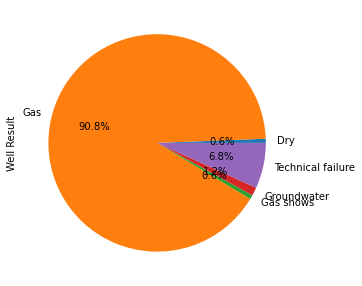

In [12]:
## Looking at the distribution of well result
well_data.groupby(['Well result']).size().plot(kind = 'pie', figsize=(5,5),autopct='%1.1f%%')
plt.ylabel('Well Result')

Text(0, 0.5, 'Number of well')

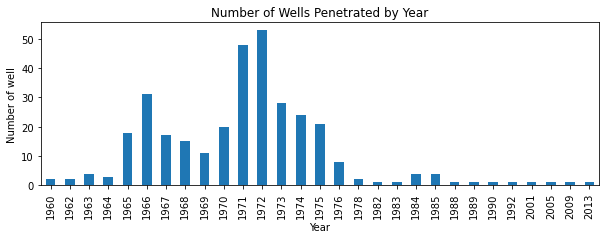

In [13]:
## Looking at the distribution of well penetration by year
well_data.groupby(well_data['Startdate drilling'].dt.year)['Startdate drilling'].size().plot(kind = 'bar', figsize=(10,3))
plt.title('Number of Wells Penetrated by Year')
plt.xlabel('Year')
plt.ylabel('Number of well')

Text(119.70915246879721, 0.5, 'Latitude')

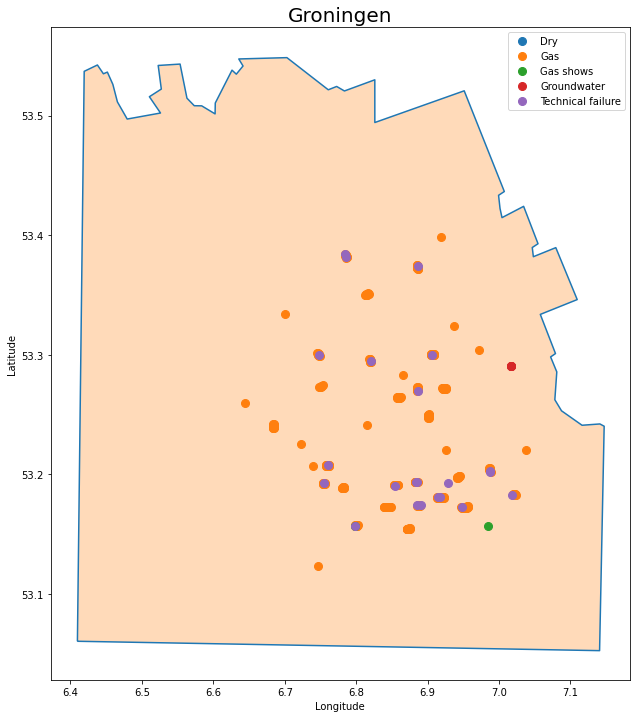

In [14]:
## Plot well locations
groups = well_data.groupby('Well result')
mapdf = gpd.read_file('Groningen_Field.zip').to_crs(4326)
#mapdf = mapdf[(mapdf["TYPE_1"] == "Provincie") & (mapdf["NAME_1"] == "Groningen")]
fig, ax = plt.subplots(figsize=(12,12))
mapdf.plot(ax=ax,facecolor='peachpuff')
for name, group in groups:
    ax.plot(group.Lon, group.Lat, marker='o', linestyle='', ms=8, label=name)
ax.legend()
plt.title('Groningen', fontsize=20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')